# HOG + SVM 

This is one of the famous object detection techniques. Here, we use the HOG feature descriptor to extract the features of the image which include the gradient magnitude and direction for each pixel. After this step, SVM will be used to detect the object in the image. 



In [1]:
from skimage import feature
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

Text(0.5, 1.0, 'HOG image')

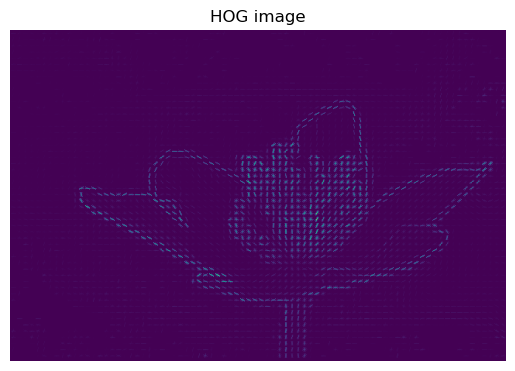

In [2]:
img = cv2.imread("flower.jpg")
(hog, hog_image) = feature.hog(img, orientations=9, 
                    pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                    block_norm='L2-Hys', visualize=True, transform_sqrt=True, channel_axis = -1)
plt.imshow(hog_image)
plt.axis("off")
plt.title("HOG image")

The above example was just taken to show how the image looks after calculating the hog features of the image.

**Now We will try to build the Hog descriptor manually only using Numpy.**

# Making HOG descriptor by Numpy

## Step 1 - Preprocessing the Image

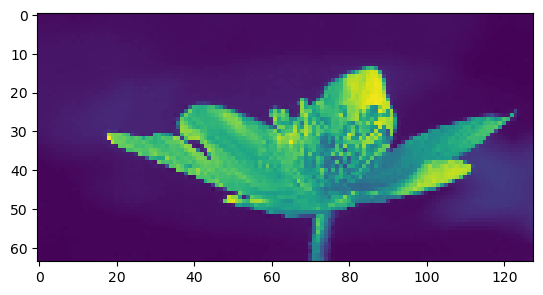

In [3]:
img_new = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (128, 64))
plt.imshow(img_new)

## Step 2 - Computing the Gradients

In [4]:
mag = []
angle = []
for i in range(64):
    mag1 = []
    angle1 = []
    for j in range(128):
        if j == 0:
            gx = img_new[i][j+1] - 0
        elif j == 127:
            gx = 0 - img_new[i][j-1]
        else:
            gx = img_new[i][j+1] - img_new[i][j-1]
        
        if i == 0:
            gy = img_new[i+1][j] - 0
        elif i == 63:
            gy = 0 - img_new[i-1][j]
        else:
            gy = img_new[i+1][j] - img_new[i-1][j]
        
        if gx == 0:
            ang = 90
        elif gy/gx >= 0:
            ang = math.degrees(math.atan(gy/gx))
        else :
            ang = 180 + math.degrees(math.atan(gy/gx))
        
        angle1.append(round(ang,5))
        mag1.append(round((gx**2 + gy**2)**(1/2),5))
        
    mag.append(mag1)
    angle.append(angle1)

C:\Users\varad\AppData\Local\Temp\ipykernel_15876\956071554.py:12: RuntimeWarning: overflow encountered in ubyte_scalars
  gx = img_new[i][j+1] - img_new[i][j-1]
C:\Users\varad\AppData\Local\Temp\ipykernel_15876\956071554.py:19: RuntimeWarning: overflow encountered in ubyte_scalars
  gy = img_new[i+1][j] - img_new[i-1][j]


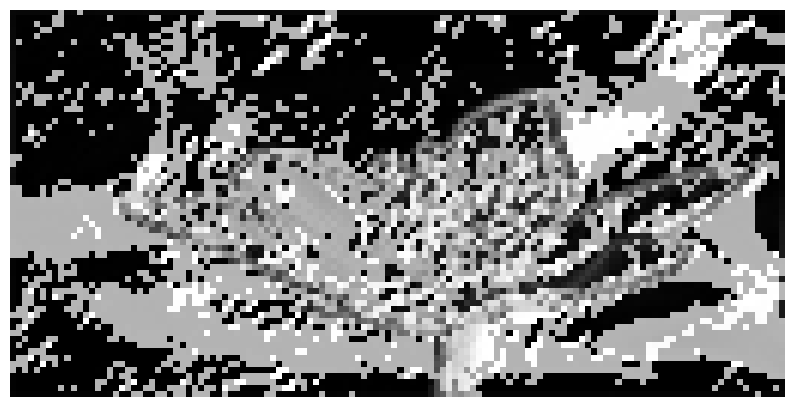

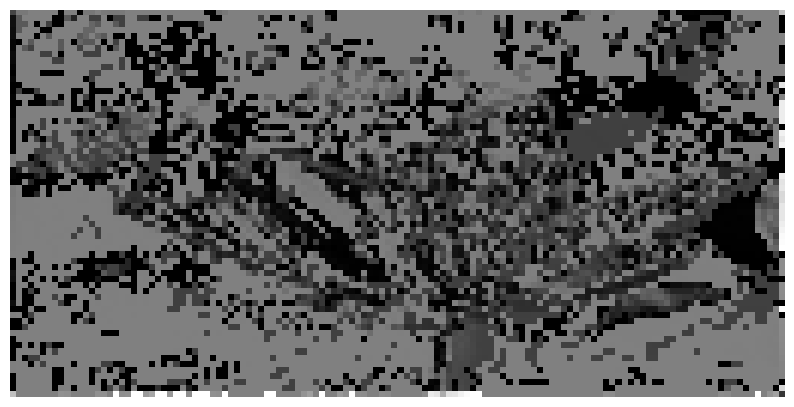

In [5]:
mag = np.array(mag)
angle = np.array(angle)

plt.figure(figsize=(10, 8))
plt.imshow(mag, cmap="gray")
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(angle, cmap="gray")
plt.axis("off")
plt.show()

## Step 3 - Binning the Gradients

Now, we will perform the binning operation on the gradients. Let us assume that the number of bins we want is z. For this example we will take z = 9.

In [6]:
z = 9
delta = 180/z
bins = []
for u in range(0,64,8):
    bins1 = []
    for x in range(0,128,8):
        bins2 = np.zeros(z)
        for v in range(8):
            for w in range(8):
                bin1  = int((angle[u+v][x+w])/delta)
                bin2 = bin1%z
                value1 = bin1*delta
                value2 = bin2*delta
                bins2[bin1]  = bins2[bin1] + (mag[i][j])*(value2 - angle[u+v][x+w])/delta
                bins2[bin2]  = bins2[bin2] + (mag[i][j])*(angle[u+v][x+w] - value1)/delta
        bins1.append(bins2)
    bins.append(bins1)

In [7]:
print(len(bins))
print(len(bins[0]))
print(len(bins[0][0]))

8
16
9


## Step 4 - Block Normalization 

In [8]:
feature_vector = []
for p in range(len(bins)-1):
    for q in range(len(bins[0])-1):
        normalize = 0
        feature1 = np.array([])
        for i in range(2):
            for j in range(2):
                normalize = normalize + np.sum((np.array(bins[p+i][q+j]))**2)
                np.append(feature,np.array(bins[p+i][q+j]))
        feature1.flatten()
        normalize = math.sqrt(normalize)
        feature1 = feature1/normalize
        feature_vector.append(feature1)

In [9]:
len(feature_vector)

105

## Step 5 - Getting the HOG feature vector

This step is already completed in the last code block. We basically needed to concatenate all the feature vectors together which we already did in the last code block. 

**Now we will move to the part where we combine both HOG feature vector and SVM**

# Combining both HOG  & SVM

In [10]:
# Importing the required libraries
from sklearn.svm import SVC
from sklearn.metrics import classification_report,accuracy_score
import glob
import os

In [11]:
feature_vector = []
y_values = []
for label in os.listdir("hog_image_recognition//input//person_car_cup"):
    for file in glob.glob("hog_image_recognition//input//person_car_cup//"+label+"//*"):
        img = cv2.imread(file)
        img = cv2.resize(img, (128, 64))
        features,hog_image = feature.hog(img, orientations=9,pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True, transform_sqrt=True, channel_axis = -1)
        feature_vector.append(features)
        y_values.append(label)

In [12]:
print(len(feature_vector[0]))

3780


## Training the model

In [13]:
classifier = SVC()
classifier.fit(feature_vector, y_values)

SVC()

## Testing the Model

In [14]:
x_test = []
images = []
for file in glob.glob("hog_image_recognition//test_images//person_car_cup//*"):
    image = cv2.imread(file)
    images.append(image)
    image = cv2.resize(image, (128, 64))
    desc, hog_image = feature.hog(image, orientations=9,pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True, transform_sqrt=True, channel_axis = -1)
    x_test.append(desc)
    
predictions = classifier.predict(x_test)

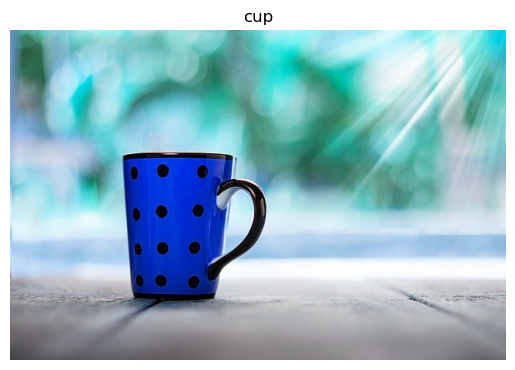

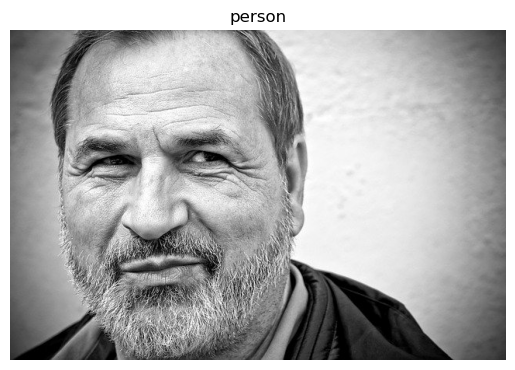

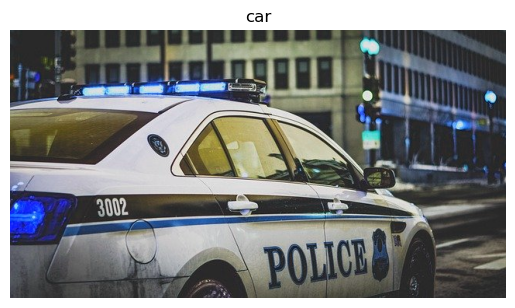

In [15]:
for i in range(3):
    plt.figure()
    plt.imshow(images[i])
    plt.axis("off")
    plt.title(predictions[i])

As we can see, the classifier has correctly predicted all the test images.